# Spatial mapping of cell types: snRNAseq from hypo to the spatial hippo (3/3) - negative control

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## Loading cell2location model output <a name="1.-Loading-cell2location-model-output"></a>

First, let's load the cell2location results. In the export step of cell2location pipeline, cell type abundances across locations are added to `sp_data` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are saved to the results directory. 

Normally, you would have the output on your system (e.g. by running  tutorial 2/3), however, you could also start with the output from our data portal:

In [2]:
results_folder = './results/mouse_brain_snrna/'
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_5experiments_46clusters_1064locations_14142genes'}

# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

if os.path.exists(f'{results_folder}{r["run_name"]}') is not True:
    os.mkdir('./results')
    os.mkdir(f'{results_folder}')
    os.system(f'cd {results_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_results/{["run_name"]}.zip')
    os.system(f'cd {results_folder} && unzip {r["run_name"]}.zip')

We load the results of the model saved into the `adata_vis` Anndata object:

In [3]:
sp_data_file = results_folder +r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Pearson correlation and heatmaps
### using cell abundance and mRNA expression data

In [4]:
from cell2location.plt.plot_heatmap import clustermap

In [5]:
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_54covariates_40064cells_14795genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for r in adata_snrna_raw.obs['group'].unique():
    ind = adata_snrna_raw.obs['group'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'group'].value_counts()

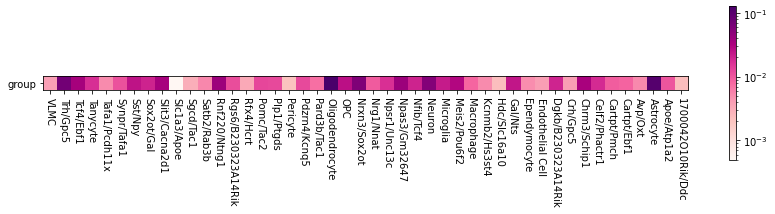

In [9]:
lay = pd.DataFrame(adata_snrna_raw.obs.loc[:, 'group'].value_counts(), 
                   index=adata_snrna_raw.obs['group'].unique())
lay = lay / lay.sum(0)

clustermap(lay.T, figure_size=(12, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

In [10]:
def abun_dist(slide, post_type = 'mean_spot_factors'):
    from re import sub

    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    infer_lay = pd.DataFrame(index=sel_clust)

    infer_lay = pd.DataFrame(np.mean(infer_lay_df.loc[:, :], axis=0), index = sel_clust)

    infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

In [11]:
infer_lay_all = abun_dist(adata_vis.copy())
infer_lay_all.head()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,0
1700042O10Rik/Ddc,0.025904
Apoe/Atp1a2,0.003807
Astrocyte,0.040881
Avp/Oxt,0.010910
Cartpt/Ebf1,0.015009


In [12]:
abd_heatmap_all = pd.concat([infer_lay_all,lay], axis = 1)
abd_heatmap_all.columns = ['inferred_value', 'true_value']

In [15]:
abd_heatmap_all.to_csv('hippo_heatmap_20210819.csv')

In [45]:
sel_clust_col = ['mean_nUMI_factors' in i for i in slide.obs.columns]
sel_clust_col = slide.obs.columns[sel_clust_col]
sel_clust = [sub('mean_nUMI_factors', '', i) for i in sel_clust_col]

infer_lay_df = slide.obs[sel_clust_col]
infer_lay_df.columns = sel_clust
infer_lay = pd.DataFrame(index=sel_clust)

infer_lay = pd.DataFrame(np.mean(infer_lay_df.loc[:, :], axis=0), index = sel_clust)
infer_lay.columns = ['inferred']

In [46]:
inf_aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'group')
inf_aver = pd.DataFrame(np.sum(inf_aver.loc[:, :], axis=0))
inf_aver.columns = ['true_value']

In [47]:
nUMI_heatmap_all = pd.concat([infer_lay, inf_aver], axis = 1)
nUMI_heatmap_all.head()

,inferred,true_value
1700042O10Rik/Ddc,478.456665,3486.580501
Apoe/Atp1a2,79.963440,3704.953317
Astrocyte,609.487732,2276.086412
Avp/Oxt,220.947235,3457.273270
Cartpt/Ebf1,287.648987,3263.186195


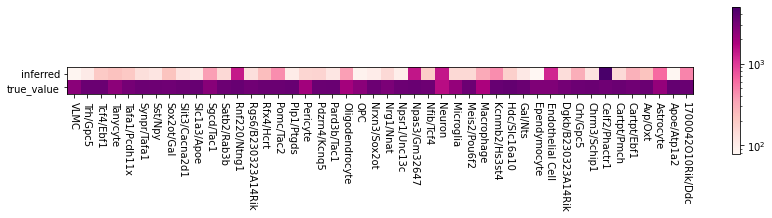

In [48]:
clustermap(nUMI_heatmap_all.T, figure_size=(12, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

investigate the individual slides/sections

In [49]:
infer_nUMI_all = abun_dist(adata_vis.copy(), post_type = 'mean_nUMI_factors')
infer_nUMI_all.columns = ['inferred']
infer_nUMI_all = infer_nUMI_all.iloc[0:46,]

true_nUMI_all = inf_aver / inf_aver.sum(0)

nUMI_heatmap_rel = pd.concat([infer_nUMI_all, true_nUMI_all], axis = 1)
nUMI_heatmap_rel.head()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,inferred,true_value
1700042O10Rik/Ddc,0.025875,0.024314
Apoe/Atp1a2,0.004285,0.025837
Astrocyte,0.034185,0.015872
Avp/Oxt,0.011879,0.024110
Cartpt/Ebf1,0.015435,0.022756


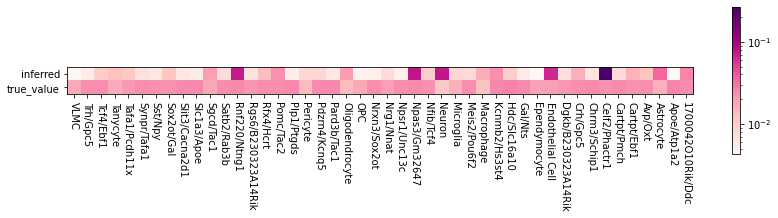

In [50]:
clustermap(nUMI_heatmap_rel.T, figure_size=(12, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

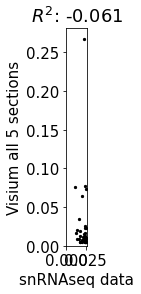

In [51]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    plot_hist2d(true_nUMI_all, infer_nUMI_all, 
                'snRNAseq data', 
                'Visium all 5 sections', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
#    plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
    plt.show()

In [18]:
infer_lay_sep = pd.DataFrame()
for i in adata_vis.obs['sample'].unique():
    infer_lay_sep[i] = abun_dist(select_slide(adata_vis, i).copy())

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call 

In [19]:
lay.columns = ['true_value']
abd_heatmap_sep = pd.concat([infer_lay_sep, lay], axis = 1)

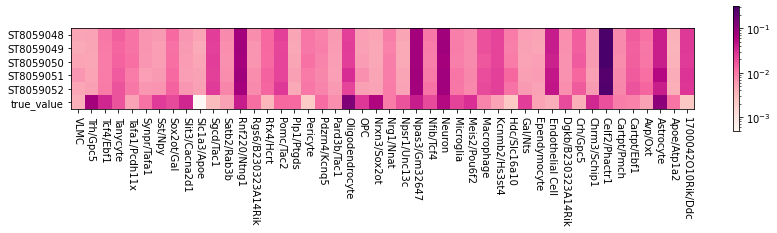

In [20]:
clustermap(abd_heatmap_sep.T, figure_size=(12, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

In [21]:
abd_heatmap_sep.to_csv('hippo_heatmap_sep_20210819.csv')

In [24]:
infer_lay_all.loc[lay.index,:]

,0
1700042O10Rik/Ddc,0.025904
Apoe/Atp1a2,0.003807
Astrocyte,0.040881
Avp/Oxt,0.010910
Cartpt/Ebf1,0.015009
Cartpt/Pmch,0.007538
Celf2/Phactr1,0.291864
Chrm3/Schip1,0.005953
Crh/Gpc5,0.014785
Dgkb/B230323A14Rik,0.006951


In [25]:
def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

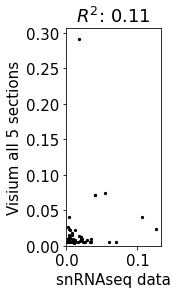

In [26]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    plot_hist2d(lay, infer_lay_all, 
                'snRNAseq data', 
                'Visium all 5 sections', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
#    plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
    plt.show()

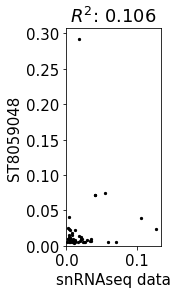

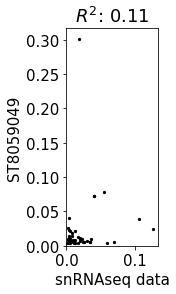

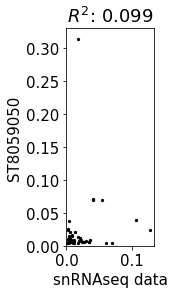

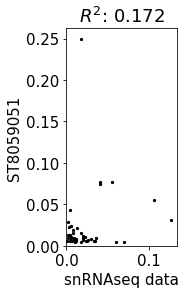

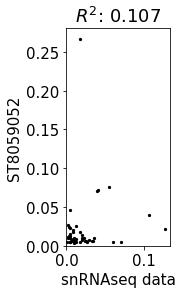

In [27]:
for i in adata_vis.obs['sample'].unique():
    with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
        plot_hist2d(lay, infer_lay_sep[i], 
                    'snRNAseq data', 
                    i, 
                   scatter_kwdargs={'s': 5, 'c': 'black'})
        plt.gca().set_aspect('equal', adjustable='box')
#       plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
        plt.show()